# Brest Cancer Prediction Using Deep Neural Network In TensorFlow 2.0



In [1]:
# import the necessary packages

import tensorflow as tf

import pandas as pd
import numpy as np 

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import random as rn
import os
%matplotlib inline

## I. Force Tensorflow to Use Single Thread for Reproducible Results

In [2]:

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results

os.environ['TF_DETERMINISTIC_OPS'] = '1'

os.environ['PYTHONHASHSEED']=str(12345)


# The below is necessary for starting core Python generated random numbers
# in a well-defined state.


rn.seed(12345)


# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below tf.set_random_seed() will make random number generation

tf.set_random_seed(1234)

## II. Load the Data

In [3]:
# load the data using numpy. Use skiprow=1 to remove the column names

bca_data = np.loadtxt("bca_clean",  delimiter=",", skiprows=1)

# Separete the features and the target in to two
unscaled_inputs = bca_data[:, 1:]
target = bca_data[:, 0]

# check that our inputs and target are of right shape.

unscaled_inputs.shape                   # our inputs have 565 observations and 30 columns
target.shape                # our target has 565 observations by 1.

(565,)

## III. Preprocessing

### Standardize


In [4]:
# - Scaling in machine learning is one of the most important step during preprocessing of data before creating machine 
# learning model.This can make a difference between a weak machine learning model and a strong one. 

# - Since our data set has values of features with different scale of measurement(ranging from fractions to hundreds), 
# scaling is necessary.


scaled_inputs = preprocessing.scale(unscaled_inputs)

# Since our data is not ordered data there is no need of shuffling.

### Split Dataset into Train, Validation, Test Split 

In [5]:
# Split the data into 80% training, 10% validation, and 10% test set.

sample_count = scaled_inputs.shape[0]                # 565 total sample to be splited


train_sample_count = int(0.8 * sample_count)

validate_sample_count = int(0.1 * sample_count)

test_sample_count = sample_count - train_sample_count - validate_sample_count



train_inputs = scaled_inputs[:train_sample_count]  # 452 samples for train inputs
train_target = target[:train_sample_count]         # 452 samples for train target


validation_inputs = scaled_inputs[train_sample_count:train_sample_count + validate_sample_count]  # 56 smaples
validation_target = target[train_sample_count:train_sample_count + validate_sample_count]         # 56 samples


test_inputs = scaled_inputs[train_sample_count + validate_sample_count : ]     # 57 samples test inputs
test_target = target[train_sample_count + validate_sample_count : ]            # 57 samples test targets

# Print the proportion of the three datasets to make sure that we did it in the right way

print(np.sum(train_target), train_sample_count, np.sum(train_target)/train_sample_count)
print(np.sum(validation_target), validate_sample_count, np.sum(validation_target)/validate_sample_count)
print(np.sum(test_target), test_sample_count, np.sum(test_target)/test_sample_count)

# From the result we can be sure that we divided our original dataset into 80% training, 10% validation, and 10% test set.

185.0 452 0.4092920353982301
11.0 56 0.19642857142857142
14.0 57 0.24561403508771928


### Save the Train, Validation, and Test Dataset in *.npz 

In [6]:
# Let's save the data in a tensor friendly format called .npz*.
# It is a simple way to combine multiple arrays into a single file,
# And the np.savez Saves several arrays into a single file in uncompressed .npz format

np.savez('bca_unshuffled_train', inputs=train_inputs, target=train_target)

np.savez('bca_unshuffled_validation', inputs=validation_inputs, target=validation_target)

np.savez('bca_unshuffled_test', inputs=test_inputs, target=test_target)

# Now our splited and scaled data is saved in *.npz format and ready

### Load the .npz* Data

In [7]:
# get train_inputs, train_target

npz_train = np.load('bca_unshuffled_train.npz')

train_inputs, train_target = npz_train['inputs'].astype(np.float), npz_train['target'].astype('int')


# Then get the validation_inputs, validation_target

npz_validate = np.load('bca_unshuffled_validation.npz')

validation_inputs, validation_target = npz_validate['inputs'].astype(np.float), npz_validate['target'].astype('int')

# Then test_inputs, test_target

npz_test = np.load('bca_unshuffled_test.npz')

test_inputs, test_target = npz_test['inputs'].astype(np.float), npz_test['target'].astype('int')



## IV. Build Model

In [8]:
# Specify the model parameters

input_size = 30                  # input size is the total number of features we have, which is 30
hidden_layer_size = 40           # After repeated fiddling we selected 40 nodes for the hidden layers
output_size = 1                  # Since our target variable is binary(Malignant or Benign) our output size would be 1


# Build model with three hidden layers that includes 'relu' activation for the hidden layers and 
# 'sigmoid' for the output layer


model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])

# compile the model using adam as optimizer, and binary_crossentropy as loss.
# accuracy and AUC will be our metrics for performanece evaluation of our model.


model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy',  tf.keras.metrics.AUC()])


# Fit the model to the training data to train the model and validation data to validate the model. 
# The purpose of Validation data is to validate the data so that we can prevent overfitting the model parameters.

# Batch size defines number of samples that going to be propagated through the network.An Epoch is a complete pass 
# through all the training data.The batch size and number of epochs have been set using trial and error. Our maximum 
# epoch is 200.After fiddling with different batch sizes we found out 64 is the best one that gives optimum result. 
# As a rule of thumb, numbers like 32, 64, 128, 256 are recommended numbers for batch size.

# We also set EarlyStopping with patience=2 inorder to prevent overfitting.
# Set the shuffle option to False inorder to get reproducible result.


batch_size = 64
epoch_max = 200
early_stopping=tf.keras.callbacks.EarlyStopping(patience=2)

fitted_model = model.fit(train_inputs, train_target, epochs=epoch_max, batch_size=batch_size, 
          validation_data=(validation_inputs, validation_target), callbacks=[early_stopping,], verbose=2, shuffle=False)


# We got a good result for both the trianing and validation data that there is no significant difference between the two.
# 1) for the training data:                                     2) For the validation data
#         - loss = 0.0203                                           - loss = 0.0510
#         - accuracy = 0.9956                                       - accuracy = 0.9821
#         - AUC = 0.9998                                            - AUC = 1.0000

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 452 samples, validate on 56 samples
Epoch 1/200
452/452 - 1s - loss: 0.6172 - acc: 0.4292 - auc: 0.9403 - val_loss: 0.6708 - val_acc: 0.3393 - val_auc: 0.9798
Epoch 2/200
452/452 - 0s - loss: 0.5085 - acc: 0.7323 - auc: 0.9813 - val_loss: 0.5640 - val_acc: 0.7500 - val_auc: 0.9838
Epoch 3/200
452/452 - 0s - loss: 0.4090 - acc: 0.9336 - auc: 0.9882 - val_loss: 0.4566 - val_acc: 0.8750 - val_auc: 0.9798
Epoch 4/200
452/452 - 0s - loss: 0.3146 - acc: 0.9646 - auc: 0.9901 - val_loss: 0.3493 - val_acc: 0.9107 - val_auc: 0.9848
Epoch 5/200
452/452 - 0s - loss: 0.2293 - acc: 0.9668 - auc: 0.9910 - val_loss: 0.2538 - val_acc: 0.9464 - val_auc: 0.9879
Epoch 6/200
452/452 - 0s - loss: 0.1637 - acc: 0.9668 - auc: 0.9919 - val_loss: 0.1816 - val_acc: 0.9464 - val_auc: 0.9919
Epoch 7/200
452/452 - 0s - loss: 0.1224 - 

### Summarize History for Loss

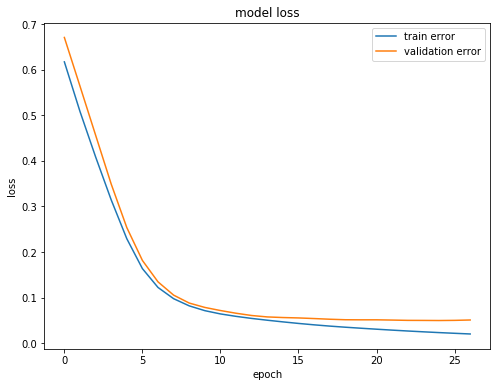

In [9]:
#  Draw plot of the training process. 

plt.figure(figsize=(8,6))
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train error', 'validation error'], loc='upper right')
plt.show()


# - Below we see a plot of the training process. 

# - We can observe that there is no big difference between the training and validation error indicating 
# that the model didn’t overfit. 

## V. Test the Model

In [10]:
# - Finally let's test the model using the test dataset. Remember, we haven't used our test dataset so far 
# as it is our reality check for unseen data.
# - The main purpose of using testing dataset is make sure that our hyperparameters are not overfitted.

test_loss, test_accuracy, test_AUC = model.evaluate(test_inputs, test_target)


57/57 [==============================] - 0s 145us/sample - loss: 0.0979 - acc: 0.9825 - auc: 0.9967


In [11]:
# Print the data in an easily readable way.

print('\nTest loss: {0:.4f}, \nTest Accuracy: {1:.2f}%, \nTest AUC: {2:.4f}'.format(test_loss, test_accuracy*100, test_AUC))




Test loss: 0.0979, 
Test Accuracy: 98.25%, 
Test AUC: 0.9967


### - Finally, we got an excellent model with AUC score of 0.9967, Accuracy of 98.25% and Loss of 0.0979.

### - Hence, our model can accurately predict 9967 of the time from 10000  digitized image of a fine needle aspirate (FNA) of a breast mass. This would be an extraoridnary finding that can be an relevant input to the healthcare industry.

In [12]:
#Predict on test set

bca_predictions = model.predict(test_inputs)
y_pred = bca_predictions > 0.5



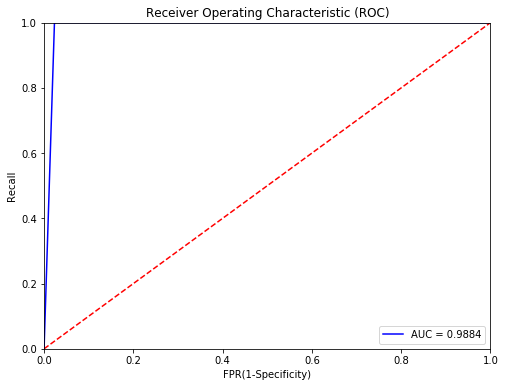

In [13]:
#Print Area Under Curve

false_positive_rate, recall, thresholds = roc_curve(test_target, y_pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.4f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('FPR(1-Specificity)')
plt.show()


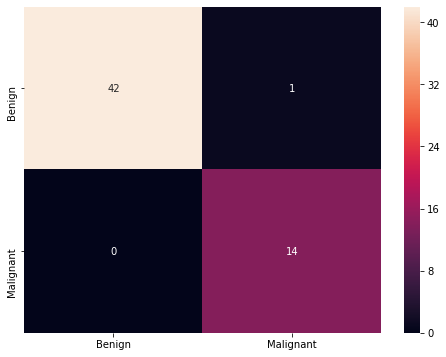

In [14]:
# Heatmap for confussion matrix

cm = confusion_matrix(test_target, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])

# - The heat map of the confusion matrix for the test data shows that out of the total 57 test observations 56 are 
# correctly predicted (42 true benign, and 14 true malignant) and only 1 incorrectly labeled as benign (false negative).

## VI. Using SHAP to Understand how our TensorFlow Model is Making Predictions

In [15]:
# -Unlike model in Scikit-learn, model in TensorFlow doesn’t have any attribute or method to calculate feature importance. 
# - Instead, we will use SHAP to understand how our TensorFlow model is making predictions.  
# -SHAP, or SHapley Additive exPlanations, is a Python library created by Scott Lundberg that can explain the 
# output of many machine learning frameworks.
# -It can help explain an individual prediction or summarize predictions across a larger population. 



# install shap by using the following code in your command prompt "conda install -c conda-forge shap"

# Once installed,  import shap

import shap


In [16]:
# change our ndarray training data (train_inputs) to pandas dataframe.

bca_clean=pd.read_csv("bca_clean")      # import our original dataframe so that we can get our column names

columns=bca_clean.drop('diagnosis', axis=1).columns.values  # get column names for all 30 features

df_shap=pd.DataFrame(np.array(train_inputs), columns=columns) # change to dataframe


# Here, df_shap is the dataframe version of our train_inputs.

In [17]:
# - Let’s start with using the KernelExplainer to draw a summary plot of the model. 
# - We will first summarize the training data into n clusters. 
# - This is an optional but helpful step, because the time to generate Shapley values increases exponentially 
# with the size of the dataset.

# Summarize the training set to accelerate analysis

df_train_summary = shap.kmeans(df_shap.values, 30)


# Instantiate an explainer with the model predictions and training data summary

explainer = shap.KernelExplainer(model.predict, df_train_summary)


# Extract Shapley values from the explainer

shap_values = explainer.shap_values(df_shap)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


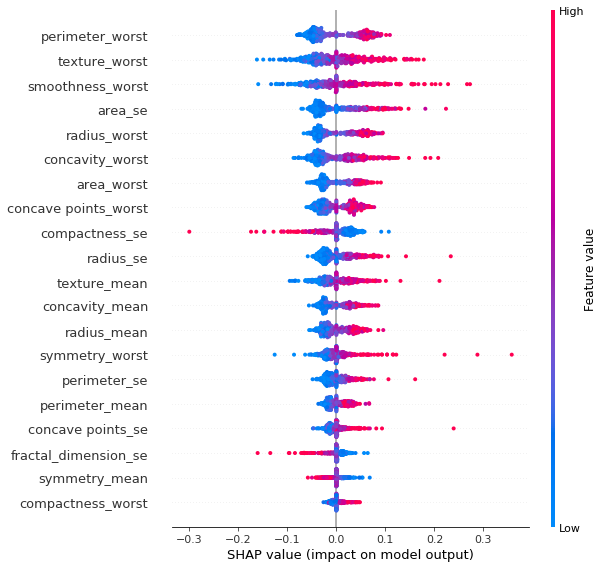

In [18]:
# Summarize the Shapley values in a plot


shap.summary_plot(shap_values[0], df_shap)

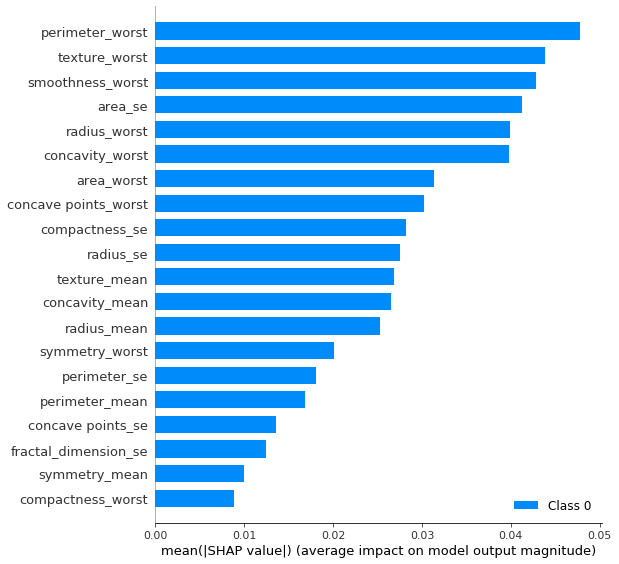

In [19]:
# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot

shap.summary_plot(shap_values, df_shap, plot_type="bar")

### Observation

#### Let’s look at some relationships from the plot.

#### - The first three features with the highest contribution are the 'perimeter_worst', 'texture_worst', 'smoothness_worst';  followed by 'area_se', 'radius_worst', 'concavity_worst', 'concave points_worst', 'area_worst'

#### - Note that each of these features have predominantly red dots (high feature values) on the right-side where there are positive SHAP values.

#### - This tells us that high values for these features lead our model to predict a malignant diagnosis.

#### - In contrary, 'compactness_se',  'fractal_dimension_se', and 'symmetry_mean' has an opposite relationship, where a lower value is associated with a malignant diagnosis.